# 1. Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# 2. Read data

In [2]:
X_train = pd.read_csv("../outputs/imputed_X_train_SMOTE_0_35.csv")
y_train = pd.read_csv("../outputs/imputed_y_train_SMOTE_0_35.csv")
X_test = pd.read_csv("../outputs/imputed_X_test_scaled_0_35.csv")
y_test = pd.read_csv("../outputs/imputed_y_test.csv")

In [3]:
X_train.head()

,GenderCategory,RaceCategory,EthnicityCategory,Age,Region,Glipizide_Final,Glimepiride_Final,Glyburide_Final,Metformin_Final,Pioglitazone_Final,...,Eye_Disorder_Final,Atherosclerosis_Final,Alzheimer_Final,FootUlcer_Final,Abnormal_Glucose_Final,DMScreen_Final,A1C_Final,GlucoseTest_Final,DM_Drugs,AnyLab
0,Female,White,Non-Hispanic,-0.387508,West,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Male,White,Non-Hispanic,-1.026402,South,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Male,White,Non-Hispanic,0.331247,Midwest,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Female,White,Non-Hispanic,1.129864,South,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,Male,White,Non-Hispanic,0.890279,Northeast,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [4]:
X_test.head()

,GenderCategory,RaceCategory,EthnicityCategory,Age,Region,Glipizide_Final,Glimepiride_Final,Glyburide_Final,Metformin_Final,Pioglitazone_Final,...,Eye_Disorder_Final,Atherosclerosis_Final,Alzheimer_Final,FootUlcer_Final,Abnormal_Glucose_Final,DMScreen_Final,A1C_Final,GlucoseTest_Final,DM_Drugs,AnyLab
0,Female,White,Non-Hispanic,-0.227785,Northeast,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Female,White,Non-Hispanic,0.171524,Midwest,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Female,White,Non-Hispanic,2.008343,South,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Male,White,Non-Hispanic,-0.307646,South,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Male,White,Non-Hispanic,0.490971,Midwest,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0


In [5]:
numerical_col = ["Age"]
categorical_col = list(X_train.columns)
categorical_col.remove("Age")
X_train[categorical_col] = X_train[categorical_col].astype('category')

In [6]:
categorical_features = X_train.columns[X_train.dtypes == 'category']
cat_col_numbers = [X_train.columns.get_loc(col) for col in X_train.select_dtypes(include="category")]
categorical_features

Index(['GenderCategory', 'RaceCategory', 'EthnicityCategory', 'Region',
       'Glipizide_Final', 'Glimepiride_Final', 'Glyburide_Final',
       'Metformin_Final', 'Pioglitazone_Final', 'Rosiglitazone_Final',
       'Beta_Blockers_Final', 'ACE_Inhibitors_Final', 'ARB_Final',
       'Diuretics_Final', 'PPI_Final', 'Levothyroxine_Final', 'CCB_Final',
       'Vasodilators_Final', 'Statins_Final', 'Anti_Platelets_Final',
       'Anti_Coagulants_Final', 'Steroids_Final', 'Heart_Disease_Final',
       'Hypothyroid_Final', 'Anemia_Final', 'Kidney_Disease_Final',
       'GERD_Final', 'Neuropathy_Final', 'Eye_Disorder_Final',
       'Atherosclerosis_Final', 'Alzheimer_Final', 'FootUlcer_Final',
       'Abnormal_Glucose_Final', 'DMScreen_Final', 'A1C_Final',
       'GlucoseTest_Final', 'DM_Drugs', 'AnyLab'],
      dtype='object')

# 3. Label Encoding

In [7]:
lbl = LabelEncoder()
for col in categorical_col:
    X_train[col] = lbl.fit_transform(X_train[col])
    X_test[col] = lbl.transform(X_test[col])

# 4. Modelling

Two GBT models:
1. HGB
2. LGBM

In [8]:
def eval(y_true, y_pred, y_pred_proba):
    acc_score = accuracy_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true,y_pred)

    prec_score = precision_score(y_true, y_pred) 
    rec_score = recall_score(y_true, y_pred)
    F1_score = f1_score(y_true, y_pred)

    roc_auc = roc_auc_score(y_true, y_pred)
    roc_auc_predict_proba = roc_auc_score(y_true, y_pred_proba)

    print(f'Accuracy: {acc_score}')

    print("Precision_score :", prec_score)
    print("recall_score :", rec_score)
    print("f1_score:", F1_score)

    print(f'ROC AUC score: {roc_auc}')
    print(f'ROC AUC PROBA: {roc_auc_predict_proba}')

    print(conf_mat)

    print("==" * 25)

In [9]:
n_splits = 5

model_params = {

    "hgb_1" : {
        "learning_rate":0.015,
        "n_iter_no_change":100,
        "l2_regularization" : 0.02,
        "random_state" : 42,
        "categorical_features" : cat_col_numbers,
    },

    "lgbm_1" :
    {
        "objective" : "binary",
        "metric" : 'AUC',
        "learning_rate" : 0.018, 
        "max_depth" : 16,
        "random_state" : 56,
        "reg_alpha" : 0.01246,
        "reg_lambda": 0.023483,
        "subsample" : 0.35,
        "colsample_bytree" : 0.8,
        "verbose" : 0,
        "num_leaves" : 11,
        "categorical_features" : cat_col_numbers,
        "verbose" : -1,
        "class_weight" : "balanced"

    }
}

hgb_1 = HistGradientBoostingClassifier(**model_params["hgb_1"])
lgbm_1 = LGBMClassifier(**model_params["lgbm_1"])

## 4.1: 5 fold StratifiedKFold to compare the two model

In [10]:
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
model_auc = {model + "_auc" : []  for model in model_params.keys()}


for num_fold, (train_index, val_index) in enumerate(kf.split(X_train,y_train.values)):
    
    print("="*20, "Fold : ", num_fold, "="*20)
    X_train_fold = X_train.iloc[train_index]
    X_val_fold = X_train.iloc[val_index]
    y_train_fold = y_train.iloc[train_index].values.ravel()
    y_val_fold = y_train.iloc[val_index].values.ravel()


    hgb_1.fit(X_train_fold, y_train_fold)
    y_pred = hgb_1.predict(X_val_fold)
    y_pred_proba = hgb_1.predict_proba(X_val_fold)[:, 1]
    model_auc["hgb_1_auc"].append(roc_auc_score(y_val_fold, y_pred))
    print('Fold', num_fold, 'HGB_1: ')
    eval(y_val_fold,y_pred, y_pred_proba)
    
    
    lgbm_1.fit(X_train_fold, y_train_fold)
    y_pred = lgbm_1.predict(X_val_fold)
    y_pred_proba = lgbm_1.predict_proba(X_val_fold)[:, 1]
    print('Fold', num_fold, 'LGBM_1: ')
    model_auc["lgbm_1_auc"].append(roc_auc_score(y_val_fold, y_pred))
    eval(y_val_fold,y_pred, y_pred_proba)


==================== Fold :  0 ====================
Fold 0 HGB_1: 
Accuracy: 0.8571428571428571
Precision_score : 0.860655737704918
recall_score : 0.963302752293578
f1_score: 0.9090909090909091
ROC AUC score: 0.7579671656204732
ROC AUC PROBA: 0.8660067600193143
[[ 21  17]
 [  4 105]]
Fold 0 LGBM_1: 
Accuracy: 0.782312925170068
Precision_score : 0.9052631578947369
recall_score : 0.7889908256880734
f1_score: 0.8431372549019608
ROC AUC score: 0.7760743602124578
ROC AUC PROBA: 0.8631096088845968
[[29  9]
 [23 86]]
==================== Fold :  1 ====================
Fold 1 HGB_1: 
Accuracy: 0.8299319727891157
Precision_score : 0.8387096774193549
recall_score : 0.9541284403669725
f1_score: 0.8927038626609441
ROC AUC score: 0.7139063254466442
ROC AUC PROBA: 0.8105987445678416
[[ 18  20]
 [  5 104]]
Fold 1 LGBM_1: 
Accuracy: 0.8095238095238095
Precision_score : 0.8648648648648649
recall_score : 0.8807339449541285
f1_score: 0.8727272727272727
ROC AUC score: 0.7429985514244326
ROC AUC PROBA: 0.8

In [11]:
sum(model_auc["hgb_1_auc"])/5, sum(model_auc["lgbm_1_auc"])/5

(0.7298862599924888, 0.7792026575102384)

#### LGBM is better classifier than HGB

# 5. Optuna Hyperparameter LGBM:

In [12]:
def objective(trial,data=X_train,target=y_train.values.ravel()):
    train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.33,random_state=42, stratify=target)
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha',1e-2,1, log = True),
        'reg_lambda': trial.suggest_float('reg_lambda',1e-2,1, log = True),
        'learning_rate': trial.suggest_float('learning_rate', 0.001,1, log = True),
        'subsample': trial.suggest_float('subsample', 0.01,1, log = True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01,1, log = True),
        'max_depth': trial.suggest_int('max_depth', 2,11),
        'max_bins': trial.suggest_int('max_bins', 5,9),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3,9),
        'num_leaves': trial.suggest_int('num_leaves', 5,11),
        "class_weight" : trial.suggest_categorical("class_weight", ["balanced"]),
        "objective" : trial.suggest_categorical("objective", ["binary"]),
        "metric" : trial.suggest_categorical("metric", ["AUC"]),
        "verbose" : trial.suggest_categorical("verbose", [-1])
    }

    model = LGBMClassifier(**params)
    model.fit(train_x, train_y)
    prediction_proba = model.predict_proba(val_x)[:, 1]
    auc = roc_auc_score(val_y, prediction_proba)
    return auc

In [13]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.ERROR)
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-12-05 22:20:43,048] A new study created in memory with name: no-name-3c304cad-89d1-4131-a14b-0a11f012017a


Number of finished trials: 100
Best trial: {'reg_alpha': 0.01025766092243618, 'reg_lambda': 0.09393252791755363, 'learning_rate': 0.014359459096092583, 'subsample': 0.19663208730459109, 'colsample_bytree': 0.5618229680239368, 'max_depth': 7, 'max_bins': 7, 'min_samples_leaf': 6, 'num_leaves': 8, 'class_weight': 'balanced', 'objective': 'binary', 'metric': 'AUC', 'verbose': -1}


In [14]:
lgbm_1 = LGBMClassifier(**study.best_trial.params)
lgbm_1.fit(X_train,y_train.values.ravel())

y_pred = lgbm_1.predict(X_train)
y_pred_proba = lgbm_1.predict_proba(X_train)[:,1]
eval(y_train, y_pred, y_pred_proba)


y_pred = lgbm_1.predict(X_test)
y_pred_proba = lgbm_1.predict_proba(X_test)[:,1]
eval(y_test, y_pred, y_pred_proba)

Accuracy: 0.8608458390177354
Precision_score : 0.9264990328820116
recall_score : 0.8821362799263351
f1_score: 0.9037735849056604
ROC AUC score: 0.8410681399631676
ROC AUC PROBA: 0.9174420858776777
[[152  38]
 [ 64 479]]
Accuracy: 0.8272727272727273
Precision_score : 0.9451476793248945
recall_score : 0.835820895522388
f1_score: 0.887128712871287
ROC AUC score: 0.8130717380837746
ROC AUC PROBA: 0.8548387096774194
[[ 49  13]
 [ 44 224]]


# 6. Save Model

In [15]:
# import joblib
# filename = '../models/LGBM/LGBM_ROC AUC PROBA: 0.854.sav'
# joblib.dump(lgbm_1, filename)
 

In [16]:
# lgbm_1.booster_.save_model("../models/LGBM_ROC AUC PROBA: 0.8601.txt")

# 7. Feature importance

In [17]:
def eval(y_true, y_pred):
    y_pred_proba = y_pred
    y_pred= np.where(y_pred > 0.5, 1, 0)

    acc_score = accuracy_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true,y_pred)

    prec_score = precision_score(y_true, y_pred) 
    rec_score = recall_score(y_true, y_pred)
    F1_score = f1_score(y_true, y_pred)

    roc_auc = roc_auc_score(y_true, y_pred)
    roc_auc_predict_proba = roc_auc_score(y_true, y_pred_proba)

    print(f'Accuracy: {acc_score}')

    print("Precision_score :", prec_score)
    print("recall_score :", rec_score)
    print("f1_score:", F1_score)

    print(f'ROC AUC score: {roc_auc}')
    print(f'ROC AUC PROBA: {roc_auc_predict_proba}')

    print(conf_mat)

    print("==" * 25)

In [18]:
lgb_1 = lgb.Booster(model_file="../models/LGBM_ROC AUC PROBA: 0.8601.txt")

In [19]:
y_pred = lgb_1.predict(X_test)
eval(y_test, y_pred)

Accuracy: 0.8363636363636363
Precision_score : 0.9349593495934959
recall_score : 0.8582089552238806
f1_score: 0.8949416342412452
ROC AUC score: 0.8000722195474242
ROC AUC PROBA: 0.8601348098218584
[[ 46  16]
 [ 38 230]]


In [20]:
y_pred = lgb_1.predict(X_train)
eval(y_train, y_pred)

Accuracy: 0.8676671214188267
Precision_score : 0.9191729323308271
recall_score : 0.9005524861878453
f1_score: 0.9097674418604651
ROC AUC score: 0.8371183483570805
ROC AUC PROBA: 0.9170252980517594
[[147  43]
 [ 54 489]]


In [21]:
# Get the feature importance
feature_importance = lgb_1.feature_importance()
sorted_features = sorted(zip(lgb_1.feature_name(), feature_importance), key=lambda x: x[1], reverse=True)
df_feat = pd.DataFrame(sorted_features, columns=["Columns", "Feature_Importance"])

In [22]:
df_feat

,Columns,Feature_Importance
0,Age,89
1,Heart_Disease_Final,52
2,Eye_Disorder_Final,50
3,CCB_Final,45
4,Abnormal_Glucose_Final,41
5,PPI_Final,39
6,GERD_Final,38
7,RaceCategory,37
8,Glyburide_Final,37
9,Region,35


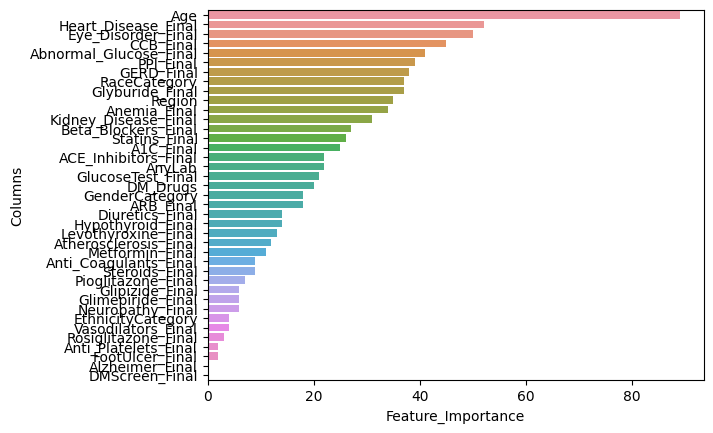

In [23]:
plt.Figure(figsize = (15,15))
sns.barplot(data = df_feat, x = "Feature_Importance", y = "Columns")
plt.show()